**This notebook borrows heavily from the following source on kaggle**

[Source article](https://www.kaggle.com/nitin194/online-store-rfm-cohort-analysis)

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objs as go
import plotly.figure_factory as ff
import datetime as dt
import os
import time

In [3]:
plt.style.use('dark_background')
mpl.rcParams['figure.figsize'] = (12, 6)

In [4]:
raw_folder = '/home/sid/mystuff/myprogs/flirt/projects/product_analytics/customer_segmentation/data/raw'

In [5]:
datapath = os.path.join(raw_folder, 'online_retail.xlsx')

In [6]:
## Import dataset
train = pd.read_excel(datapath, parse_dates=['InvoiceDate'], engine='openpyxl')

In [7]:
train.shape

(541909, 8)

In [8]:
train.head()

InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice  CustomerID         Country  
0 2010-12-01 08:26:00       2.55     17850.0  United Kingdom  
1 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
2 2010-12-01 08:26:00       2.75     17850.0  United Kingdom  
3 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
4 2010-12-01 08:26:00       3.39     17850.0  United Kingdom

In [9]:
## check for duplicate items
train.duplicated().sum()

5268

In [10]:
## remove duplicated items
train = train[~train.duplicated()]

In [11]:
## check for missing values
train.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135037
Country             0
dtype: int64

In [12]:
## create a list of unique InvoiceNo with null CustomerID records
Invoice_list = train[train['CustomerID'].isnull()]['InvoiceNo'].tolist()

Invoice_list

[536414,
 536544,
 536544,
 536544,
 536544,
 536544,
 536544,
 536544,
 536544,
 536544,
 536544,
 536544,
 536544,
 536544,
 536544,
 536544,
 536544,
 536544,
 536544,
 536544,
 536544,
 536544,
 536544,
 536544,
 536544,
 536544,
 536544,
 536544,
 536544,
 536544,
 536544,
 536544,
 536544,
 536544,
 536544,
 536544,
 536544,
 536544,
 536544,
 536544,
 536544,
 536544,
 536544,
 536544,
 536544,
 536544,
 536544,
 536544,
 536544,
 536544,
 536544,
 536544,
 536544,
 536544,
 536544,
 536544,
 536544,
 536544,
 536544,
 536544,
 536544,
 536544,
 536544,
 536544,
 536544,
 536544,
 536544,
 536544,
 536544,
 536544,
 536544,
 536544,
 536544,
 536544,
 536544,
 536544,
 536544,
 536544,
 536544,
 536544,
 536544,
 536544,
 536544,
 536544,
 536544,
 536544,
 536544,
 536544,
 536544,
 536544,
 536544,
 536544,
 536544,
 536544,
 536544,
 536544,
 536544,
 536544,
 536544,
 536544,
 536544,
 536544,
 536544,
 536544,
 536544,
 536544,
 536544,
 536544,
 536544,
 536544,
 536544,
 

In [13]:
## Check number of records with these invoice number
len(train[train.InvoiceNo.isin(Invoice_list)])

135037

In [14]:
## Removing records with null customer IDs
rfm_train = train[train['CustomerID'].notnull()].copy()

In [15]:
rfm_train.shape

(401604, 8)

In [16]:
rfm_train.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 401604 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    401604 non-null  object        
 1   StockCode    401604 non-null  object        
 2   Description  401604 non-null  object        
 3   Quantity     401604 non-null  int64         
 4   InvoiceDate  401604 non-null  datetime64[ns]
 5   UnitPrice    401604 non-null  float64       
 6   CustomerID   401604 non-null  float64       
 7   Country      401604 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 103.0 MB


In [17]:
rfm_train['CustomerID'] = rfm_train['CustomerID'].astype(int)

In [18]:
rfm_train.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 401604 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    401604 non-null  object        
 1   StockCode    401604 non-null  object        
 2   Description  401604 non-null  object        
 3   Quantity     401604 non-null  int64         
 4   InvoiceDate  401604 non-null  datetime64[ns]
 5   UnitPrice    401604 non-null  float64       
 6   CustomerID   401604 non-null  int64         
 7   Country      401604 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(4)
memory usage: 103.0 MB


In [19]:
rfm_train.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

#### **Check for cancelled items**

In [20]:
desc_df = rfm_train[~rfm_train['InvoiceNo'].str.contains('C', na=False)]

In [21]:
## Lets create total cost feature
desc_df['Total_cost'] = rfm_train['Quantity'] * rfm_train['UnitPrice']

In [22]:
desc_df.head()

InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice  CustomerID         Country  Total_cost  
0 2010-12-01 08:26:00       2.55       17850  United Kingdom       15.30  
1 2010-12-01 08:26:00       3.39       17850  United Kingdom       20.34  
2 2010-12-01 08:26:00       2.75       17850  United Kingdom       22.00  
3 2010-12-01 08:26:00       3.39       17850  United Kingdom       20.34  
4 2010-12-01 08:26:00       3.39       17850  United Kingdom       20.34

### EDA

In [23]:
print(f'Oldest date is - {desc_df.InvoiceDate.min()}\n')
print(f'Latest date is - {desc_df.InvoiceDate.max()}')

Oldest date is - 2010-12-01 08:26:00

Latest date is - 2011-12-09 12:50:00


In [24]:
# Check the top ten countries in the dataset with highest transactions
desc_df.Country.value_counts(normalize=True).head(10).mul(100).round(1).astype(str) + '%'

United Kingdom    88.9%
Germany            2.3%
France             2.1%
EIRE               1.8%
Spain              0.6%
Netherlands        0.6%
Belgium            0.5%
Switzerland        0.5%
Portugal           0.4%
Australia          0.3%
Name: Country, dtype: object

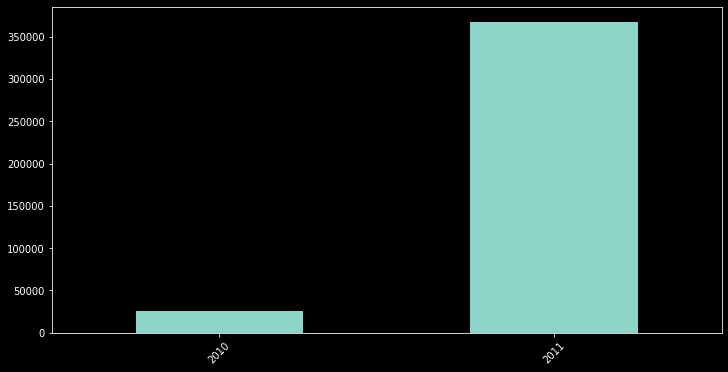

In [25]:
# Count of transactions in different years
desc_df.InvoiceDate.dt.year.value_counts(sort=False).plot(kind='bar', rot=45);

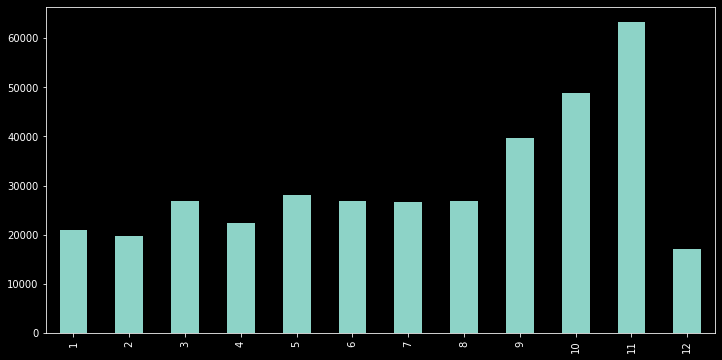

In [26]:
# Count of transactions in different months within 2011 year.
desc_df[desc_df.InvoiceDate.dt.year==2011].InvoiceDate.dt.month.value_counts(sort=False).plot(kind='bar');

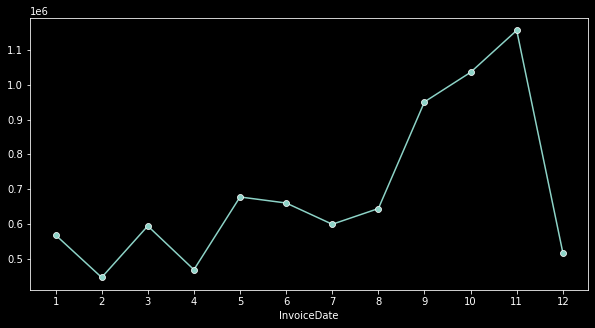

In [27]:
# Let's visualize the top grossing months
monthly_gross = desc_df[desc_df.InvoiceDate.dt.year==2011].groupby(desc_df.InvoiceDate.dt.month).Total_cost.sum()
plt.figure(figsize=(10,5))
sns.lineplot(y=monthly_gross.values,x=monthly_gross.index, marker='o');
plt.xticks(range(1,13))
plt.show();

In [28]:
desc_df.describe().T

count          mean          std      min       25%       50%  \
Quantity    392732.0     13.153718   181.588420      1.0      2.00      6.00   
UnitPrice   392732.0      3.125596    22.240725      0.0      1.25      1.95   
CustomerID  392732.0  15287.734822  1713.567773  12346.0  13955.00  15150.00   
Total_cost  392732.0     22.629195   311.083465      0.0      4.95     12.39   

                 75%        max  
Quantity       12.00   80995.00  
UnitPrice       3.75    8142.75  
CustomerID  16791.00   18287.00  
Total_cost     19.80  168469.60

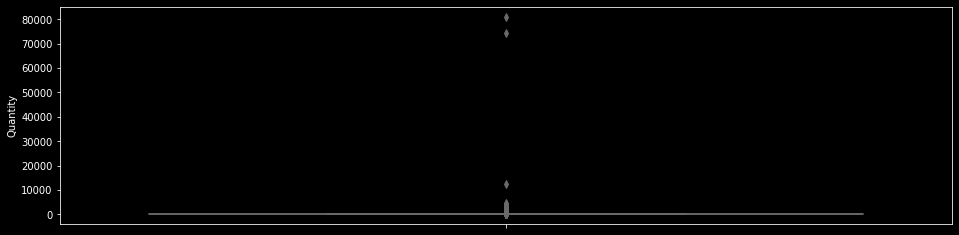

In [29]:
# Boxplot to visualize the Quantity distribution
plt.figure(figsize=(16,4))
sns.boxplot(y='Quantity', data=desc_df, orient='h');

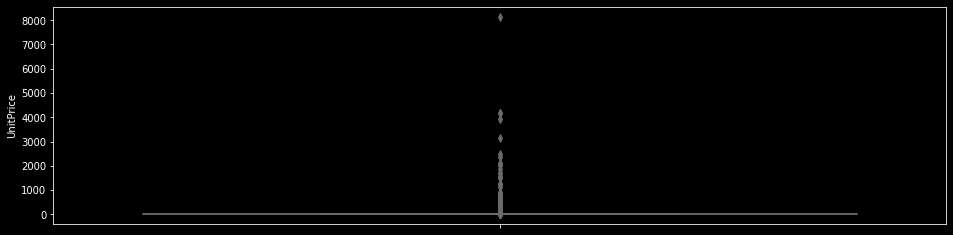

In [30]:
# Let's visualize the Unit price distribution
plt.figure(figsize=(16,4))
sns.boxplot(y='UnitPrice', data=desc_df, orient='h');

In [31]:
# Let's visualize some top products from the whole range.
top_products = desc_df['Description'].value_counts()[:20]

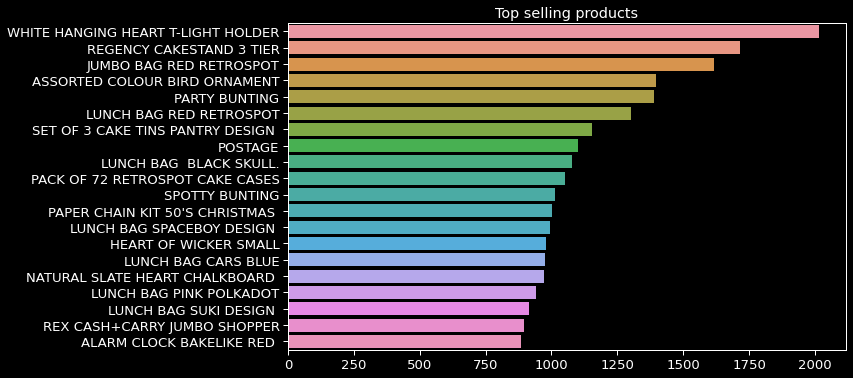

In [32]:
plt.figure(figsize=(10,6))
sns.set_context("paper", font_scale=1.5)
sns.barplot(y = top_products.index,
            x = top_products.values)
plt.title("Top selling products")
plt.show();

### Cohort Analysis

**Cohort Analysis**

A cohort is a group of subjects who share a defining characteristic. We can observe how a cohort behaves across time and compare it to other cohorts.

Types of cohorts:
> **Time Cohorts** are customers who signed up for a product or service during a particular time frame. Analyzing these cohorts shows the customers’ behavior depending on the time they started using the company’s products or services. The time may be monthly or quarterly even daily.

> **Behavior cohorts** are customers who purchased a product or subscribed to a service in the past. It groups customers by the type of product or service they signed up. Customers who signed up for basic level services might have different needs than those who signed up for advanced services. Understaning the needs of the various cohorts can help a company design custom-made services or products for particular segments.

> **Size cohorts** refer to the various sizes of customers who purchase company’s products or services. This categorization can be based on the amount of spending in some periodic time after acquisition or the product type that the customer spent most of their order amount in some period of time.

**For cohort analysis, there are a few labels that we have to create:**

**Invoice period** - A string representation of the year and month of a single transaction/invoice.

**Cohort group** - A string representation of the the year and month of a customer’s first purchase. This label is common across all invoices for a particular customer.

**Cohort period/Index** -  A integer representation a customer’s stage in its “lifetime”. The number represents the number of months passed since the first purchase.

In [33]:
## create a copy of rfm_train df for cohort analysis
cohort = rfm_train.copy()

**Assign monthly acquisition cohort**

Defining a cohort is the first step to cohort analysis. We will now create monthly cohorts based on the month each customer has made their first transaction.

In [34]:
## function to parse dates
def get_month(x):
    return dt.datetime(x.year, x.month, 1)

In [35]:
## Create InvoiceMonth Column
cohort['InvoiceMonth'] = cohort['InvoiceDate'].apply(get_month)

In [36]:
cohort.head()

InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice  CustomerID         Country InvoiceMonth  
0 2010-12-01 08:26:00       2.55       17850  United Kingdom   2010-12-01  
1 2010-12-01 08:26:00       3.39       17850  United Kingdom   2010-12-01  
2 2010-12-01 08:26:00       2.75       17850  United Kingdom   2010-12-01  
3 2010-12-01 08:26:00       3.39       17850  United Kingdom   2010-12-01  
4 2010-12-01 08:26:00       3.39       17850  United Kingdom   2010-12-01

In [37]:
## Group by CustomerID and select InvoiceMonth Value
grouping = cohort.groupby('CustomerID')['InvoiceMonth']

In [38]:
## Assign a minimum InvoiceMonth value to the dataset
cohort['CohortMonth'] = grouping.transform('min')

##### Calculate time offset in months

In [39]:
def get_date_int(df, column):
    year = df[column].dt.year
    month = df[column].dt.month
    return year, month

In [40]:
invoice_year, invoice_month = get_date_int(cohort, 'InvoiceMonth')

In [41]:
cohort_year, cohort_month = get_date_int(cohort, 'CohortMonth')

In [42]:
years_diff = invoice_year - cohort_year

In [43]:
months_diff = invoice_month - cohort_month

In [44]:
cohort['CohortIndex'] = years_diff * 12 + months_diff + 1

In [45]:
cohort.head()

InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice  CustomerID         Country InvoiceMonth  \
0 2010-12-01 08:26:00       2.55       17850  United Kingdom   2010-12-01   
1 2010-12-01 08:26:00       3.39       17850  United Kingdom   2010-12-01   
2 2010-12-01 08:26:00       2.75       17850  United Kingdom   2010-12-01   
3 2010-12-01 08:26:00       3.39       17850  United Kingdom   2010-12-01   
4 2010-12-01 08:26:00       3.39       17850  United Kingdom   2010-12-01   

  CohortMonth  CohortIndex  
0  2010-12-01            1  
1  2010-12-01            1  
2  2010-12-01            1  
3  2010-12-01            1  
4  2010-12-01            1

#### Calculate Retention Rate 

In [46]:
grouping = cohort.groupby(['CohortMonth', 'CohortIndex'])

In [47]:
cohort_data = grouping['CustomerID'].apply(pd.Series.nunique).reset_index()

In [48]:
cohort_data

CohortMonth  CohortIndex  CustomerID
0   2010-12-01            1         948
1   2010-12-01            2         362
2   2010-12-01            3         317
3   2010-12-01            4         367
4   2010-12-01            5         341
..         ...          ...         ...
86  2011-10-01            2          93
87  2011-10-01            3          46
88  2011-11-01            1         321
89  2011-11-01            2          43
90  2011-12-01            1          41

[91 rows x 3 columns]

In [49]:
cohort_counts = cohort_data.pivot(index='CohortMonth', 
                                  columns='CohortIndex', 
                                  values='CustomerID')

In [50]:
cohort_counts

CohortIndex     1      2      3      4      5      6      7      8      9   \
CohortMonth                                                                  
2010-12-01   948.0  362.0  317.0  367.0  341.0  376.0  360.0  336.0  336.0   
2011-01-01   421.0  101.0  119.0  102.0  138.0  126.0  110.0  108.0  131.0   
2011-02-01   380.0   94.0   73.0  106.0  102.0   94.0   97.0  107.0   98.0   
2011-03-01   440.0   84.0  112.0   96.0  102.0   78.0  116.0  105.0  127.0   
2011-04-01   299.0   68.0   66.0   63.0   62.0   71.0   69.0   78.0   25.0   
2011-05-01   279.0   66.0   48.0   48.0   60.0   68.0   74.0   29.0    NaN   
2011-06-01   235.0   49.0   44.0   64.0   58.0   79.0   24.0    NaN    NaN   
2011-07-01   191.0   40.0   39.0   44.0   52.0   22.0    NaN    NaN    NaN   
2011-08-01   167.0   42.0   42.0   42.0   23.0    NaN    NaN    NaN    NaN   
2011-09-01   298.0   89.0   97.0   36.0    NaN    NaN    NaN    NaN    NaN   
2011-10-01   352.0   93.0   46.0    NaN    NaN    NaN    NaN    NaN    NaN   
2011-11-01   321.0   43.0    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2011-12-01    41.0    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   

CohortIndex     10     11     12     13  
CohortMonth                              
2010-12-01   374.0  354.0  474.0  260.0  
2011-01-01   146.0  155.0   63.0    NaN  
2011-02-01   119.0   35.0    NaN    NaN  
2011-03-01    39.0    NaN    NaN    NaN  
2011-04-01     NaN    NaN    NaN    NaN  
2011-05-01     NaN    NaN    NaN    NaN  
2011-06-01     NaN    NaN    NaN    NaN  
2011-07-01     NaN    NaN    NaN    NaN  
2011-08-01     NaN    NaN    NaN    NaN  
2011-09-01     NaN    NaN    NaN    NaN  
2011-10-01     NaN    NaN    NaN    NaN  
2011-11-01     NaN    NaN    NaN    NaN  
2011-12-01     NaN    NaN    NaN    NaN

In [51]:
cohort_sizes = cohort_counts.iloc[:, 0]
cohort_sizes

CohortMonth
2010-12-01    948.0
2011-01-01    421.0
2011-02-01    380.0
2011-03-01    440.0
2011-04-01    299.0
2011-05-01    279.0
2011-06-01    235.0
2011-07-01    191.0
2011-08-01    167.0
2011-09-01    298.0
2011-10-01    352.0
2011-11-01    321.0
2011-12-01     41.0
Name: 1, dtype: float64

In [52]:
retention = cohort_counts.divide(cohort_sizes, axis=0) * 100

In [53]:
retention

CohortIndex     1          2          3          4          5          6   \
CohortMonth                                                                 
2010-12-01   100.0  38.185654  33.438819  38.713080  35.970464  39.662447   
2011-01-01   100.0  23.990499  28.266033  24.228029  32.779097  29.928741   
2011-02-01   100.0  24.736842  19.210526  27.894737  26.842105  24.736842   
2011-03-01   100.0  19.090909  25.454545  21.818182  23.181818  17.727273   
2011-04-01   100.0  22.742475  22.073579  21.070234  20.735786  23.745819   
2011-05-01   100.0  23.655914  17.204301  17.204301  21.505376  24.372760   
2011-06-01   100.0  20.851064  18.723404  27.234043  24.680851  33.617021   
2011-07-01   100.0  20.942408  20.418848  23.036649  27.225131  11.518325   
2011-08-01   100.0  25.149701  25.149701  25.149701  13.772455        NaN   
2011-09-01   100.0  29.865772  32.550336  12.080537        NaN        NaN   
2011-10-01   100.0  26.420455  13.068182        NaN        NaN        NaN   
2011-11-01   100.0  13.395639        NaN        NaN        NaN        NaN   
2011-12-01   100.0        NaN        NaN        NaN        NaN        NaN   

CohortIndex         7          8          9          10         11         12  \
CohortMonth                                                                     
2010-12-01   37.974684  35.443038  35.443038  39.451477  37.341772  50.000000   
2011-01-01   26.128266  25.653207  31.116390  34.679335  36.817102  14.964371   
2011-02-01   25.526316  28.157895  25.789474  31.315789   9.210526        NaN   
2011-03-01   26.363636  23.863636  28.863636   8.863636        NaN        NaN   
2011-04-01   23.076923  26.086957   8.361204        NaN        NaN        NaN   
2011-05-01   26.523297  10.394265        NaN        NaN        NaN        NaN   
2011-06-01   10.212766        NaN        NaN        NaN        NaN        NaN   
2011-07-01         NaN        NaN        NaN        NaN        NaN        NaN   
2011-08-01         NaN        NaN        NaN        NaN        NaN        NaN   
2011-09-01         NaN        NaN        NaN        NaN        NaN        NaN   
2011-10-01         NaN        NaN        NaN        NaN        NaN        NaN   
2011-11-01         NaN        NaN        NaN        NaN        NaN        NaN   
2011-12-01         NaN        NaN        NaN        NaN        NaN        NaN   

CohortIndex        13  
CohortMonth            
2010-12-01   27.42616  
2011-01-01        NaN  
2011-02-01        NaN  
2011-03-01        NaN  
2011-04-01        NaN  
2011-05-01        NaN  
2011-06-01        NaN  
2011-07-01        NaN  
2011-08-01        NaN  
2011-09-01        NaN  
2011-10-01        NaN  
2011-11-01        NaN  
2011-12-01        NaN

In [54]:
month_list = ["Dec '10", "Jan '11", "Feb '11", "Mar '11", "Apr '11",\
              "May '11", "Jun '11", "Jul '11", "Aug '11", "Sep '11", \
              "Oct '11", "Nov '11", "Dec '11"]

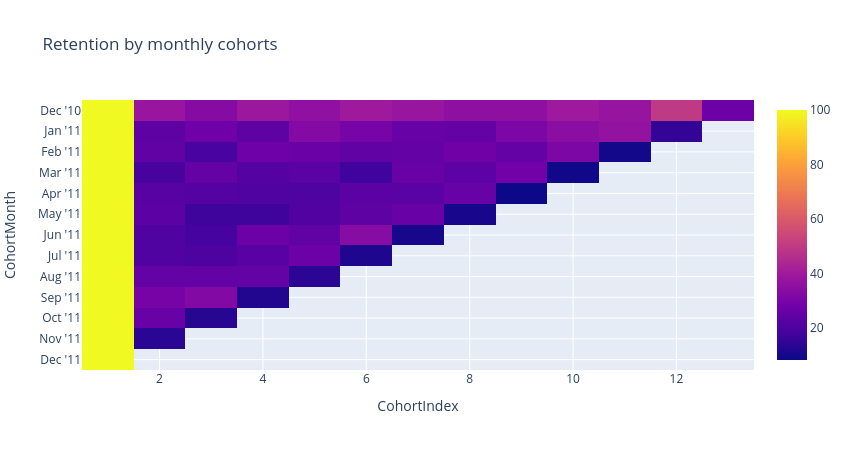

In [55]:
px.imshow(
    img=retention,
    zmin=0.0,
    title='Retention by monthly cohorts',
    y = month_list
).show()

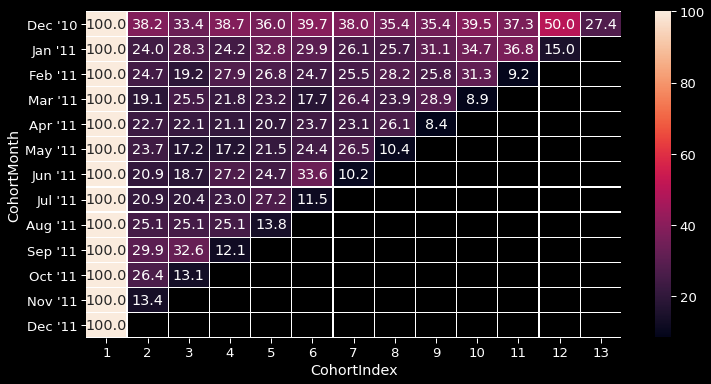

In [56]:
sns.heatmap(data=retention, 
            annot=True, 
            fmt='.1f', 
            linewidth=0.2, 
            yticklabels=month_list)
plt.show()

### Calculate average price of unit per cohort

In [57]:
grouping = cohort.groupby(['CohortMonth', 'CohortIndex'])

cohort_data = grouping['UnitPrice'].mean()

In [58]:
cohort_data

CohortMonth  CohortIndex
2010-12-01   1              3.216682
             2              3.182040
             3              3.207467
             4              3.603758
             5              2.937803
                              ...   
2011-10-01   2              2.678140
             3              2.596869
2011-11-01   1              2.641554
             2              2.335018
2011-12-01   1              2.288479
Name: UnitPrice, Length: 91, dtype: float64

In [59]:
cohort_data = cohort_data.reset_index()

In [60]:
average_price = cohort_data.pivot(index='CohortMonth', 
                                  columns='CohortIndex', 
                                  values='UnitPrice')

In [61]:
average_price.round(1)

CohortIndex    1    2    3    4    5    6    7    8    9    10   11   12   13
CohortMonth                                                                  
2010-12-01    3.2  3.2  3.2  3.6  2.9  5.0  3.2  3.2  3.5  3.0  3.3  2.8  2.8
2011-01-01    3.5  3.7  3.1  8.4  3.2  3.2  2.9  2.7  2.6  5.5  2.9  2.6  NaN
2011-02-01    3.4  4.5  4.8  3.2  3.0  2.8  2.8  3.2  2.9  2.9  3.2  NaN  NaN
2011-03-01    3.3  5.0  3.7  3.3  3.6  2.8  2.8  2.8  2.7  2.5  NaN  NaN  NaN
2011-04-01    3.4  4.0  3.3  2.7  3.0  2.9  2.9  2.8  2.6  NaN  NaN  NaN  NaN
2011-05-01    4.7  3.2  2.7  3.2  2.7  2.5  2.6  2.6  NaN  NaN  NaN  NaN  NaN
2011-06-01   10.5  3.2  3.3  2.8  2.6  3.6  2.3  NaN  NaN  NaN  NaN  NaN  NaN
2011-07-01    4.5  3.5  2.8  2.7  2.4  2.4  NaN  NaN  NaN  NaN  NaN  NaN  NaN
2011-08-01    3.0  5.4  5.7  7.0  6.8  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN
2011-09-01    3.2  3.6  3.0  2.6  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN
2011-10-01    4.1  2.7  2.6  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN
2011-11-01    2.6  2.3  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN
2011-12-01    2.3  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN

In [62]:
average_price.index = average_price.index.date

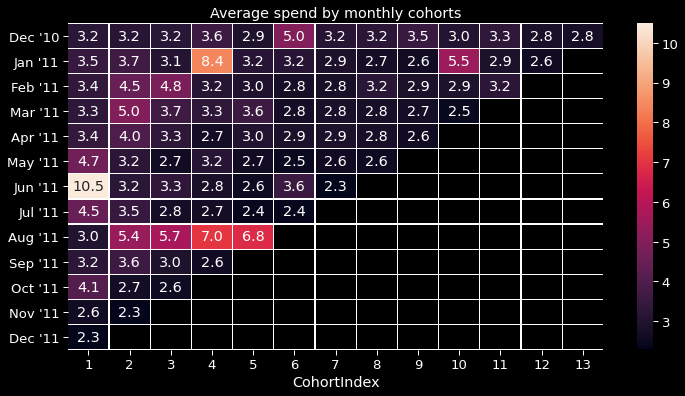

In [63]:
sns.heatmap(data=average_price, 
            annot=True, 
            fmt='.1f', 
            linewidth=0.2, 
            yticklabels=month_list)
plt.title('Average spend by monthly cohorts')
plt.show()

##### Average quantity per cohort

In [64]:
cohort_data = grouping['Quantity'].mean()
cohort_data

CohortMonth  CohortIndex
2010-12-01   1              11.200463
             2              14.691852
             3              15.108447
             4              14.954097
             5              13.054649
                              ...    
2011-10-01   2               7.056196
             3               8.079686
2011-11-01   1               8.901297
             2               9.508021
2011-12-01   1              14.795478
Name: Quantity, Length: 91, dtype: float64

In [65]:
cohort_data = cohort_data.reset_index()

In [66]:
cohort_data

CohortMonth  CohortIndex   Quantity
0   2010-12-01            1  11.200463
1   2010-12-01            2  14.691852
2   2010-12-01            3  15.108447
3   2010-12-01            4  14.954097
4   2010-12-01            5  13.054649
..         ...          ...        ...
86  2011-10-01            2   7.056196
87  2011-10-01            3   8.079686
88  2011-11-01            1   8.901297
89  2011-11-01            2   9.508021
90  2011-12-01            1  14.795478

[91 rows x 3 columns]

In [67]:
# Create a pivot 
average_quantity = cohort_data.pivot(index='CohortMonth', columns='CohortIndex', values='Quantity')

In [68]:
average_quantity.round(2)

CohortIndex     1      2      3      4      5      6      7      8      9   \
CohortMonth                                                                  
2010-12-01   11.20  14.69  15.11  14.95  13.05  14.42  15.31  14.88  16.76   
2011-01-01   10.13  12.70  12.43  11.03  12.29  15.01  14.30  14.52  11.45   
2011-02-01   10.92  12.25  18.56  12.02  11.17  11.48  13.38  12.45  10.38   
2011-03-01    9.82   9.97  12.25   9.48  13.04  12.37  13.22  12.26  10.66   
2011-04-01    9.80  10.13   9.43  11.62  11.65   8.32   9.78   9.48   7.40   
2011-05-01   10.98   9.14  14.02  11.81  10.97   8.74  10.28   7.58    NaN   
2011-06-01   10.41  13.86  10.51  13.38  10.36   9.90   9.35    NaN    NaN   
2011-07-01    9.80  12.70   7.23   7.93   6.10   7.11    NaN    NaN    NaN   
2011-08-01    9.94   5.98   5.37   5.97   6.98    NaN    NaN    NaN    NaN   
2011-09-01   12.00   5.55   7.66   8.87    NaN    NaN    NaN    NaN    NaN   
2011-10-01    8.55   7.06   8.08    NaN    NaN    NaN    NaN    NaN    NaN   
2011-11-01    8.90   9.51    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2011-12-01   14.80    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   

CohortIndex     10     11     12    13  
CohortMonth                             
2010-12-01   16.81  17.53  13.02  14.9  
2011-01-01    9.98   9.26   9.74   NaN  
2011-02-01   12.04  12.70    NaN   NaN  
2011-03-01    9.09    NaN    NaN   NaN  
2011-04-01     NaN    NaN    NaN   NaN  
2011-05-01     NaN    NaN    NaN   NaN  
2011-06-01     NaN    NaN    NaN   NaN  
2011-07-01     NaN    NaN    NaN   NaN  
2011-08-01     NaN    NaN    NaN   NaN  
2011-09-01     NaN    NaN    NaN   NaN  
2011-10-01     NaN    NaN    NaN   NaN  
2011-11-01     NaN    NaN    NaN   NaN  
2011-12-01     NaN    NaN    NaN   NaN

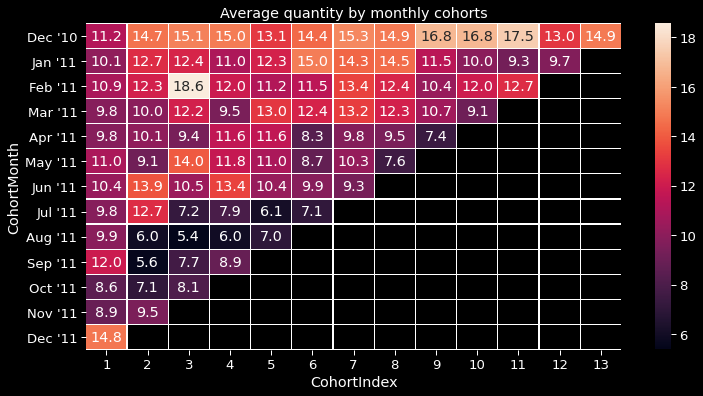

In [69]:
sns.heatmap(data=average_quantity, 
            annot=True, 
            fmt='.1f', 
            linewidth=0.2, 
            yticklabels=month_list)
plt.title('Average quantity by monthly cohorts')
plt.show()

## **RFM Analysis**

RFM analysis is a customer segmentation technique that uses past purchase behavior to divide customers into groups. RFM helps divide customers into various categories or clusters to identify customers who are more likely to respond to promotions and also for future personalization services.

Recency (R): Time since last purchase
Frequency (F): Total number of purchases
Monetary (M): Total purchase value

***Benefits of RFM analysis***
Increased customer retention
Increased response rate
Increased conversion rate
Increased revenue

To perform RFM analysis, we divide customers into four equal groups according to the distribution of values for recency, frequency, and monetary value. Four equal groups across three variables create 64 (4x4x4) different customer segments, which is a manageable number.

For example, let’s look at a customer who:

is within the group who purchased most recently (R=4),

is within the group who purchased most quantity (F=4),

is within the group who spent the most (M=4)

This customer belongs to RFM segment 4-4-4 (Best Customers), (R=4, F=4, M=4)

### Recency

In [70]:
current_date = rfm_train['InvoiceDate'].max().date()

In [71]:
rfm_train['Purchase_Date'] = rfm_train.InvoiceDate.dt.date

In [72]:
recency = rfm_train.groupby('CustomerID')['Purchase_Date'].max().reset_index()

In [73]:
recency

CustomerID Purchase_Date
0          12346    2011-01-18
1          12347    2011-12-07
2          12348    2011-09-25
3          12349    2011-11-21
4          12350    2011-02-02
...          ...           ...
4367       18280    2011-03-07
4368       18281    2011-06-12
4369       18282    2011-12-02
4370       18283    2011-12-06
4371       18287    2011-10-28

[4372 rows x 2 columns]

In [74]:
recency['Current_Date'] = current_date

In [75]:
recency

CustomerID Purchase_Date Current_Date
0          12346    2011-01-18   2011-12-09
1          12347    2011-12-07   2011-12-09
2          12348    2011-09-25   2011-12-09
3          12349    2011-11-21   2011-12-09
4          12350    2011-02-02   2011-12-09
...          ...           ...          ...
4367       18280    2011-03-07   2011-12-09
4368       18281    2011-06-12   2011-12-09
4369       18282    2011-12-02   2011-12-09
4370       18283    2011-12-06   2011-12-09
4371       18287    2011-10-28   2011-12-09

[4372 rows x 3 columns]

In [76]:
## Compute the number of days since last purchase
recency['Recency'] = recency['Purchase_Date'].apply(lambda x: (current_date - x).days)

In [77]:
recency.head()

CustomerID Purchase_Date Current_Date  Recency
0       12346    2011-01-18   2011-12-09      325
1       12347    2011-12-07   2011-12-09        2
2       12348    2011-09-25   2011-12-09       75
3       12349    2011-11-21   2011-12-09       18
4       12350    2011-02-02   2011-12-09      310

In [78]:
recency.drop(['Purchase_Date', 'Current_Date'], axis=1, inplace=True)

### Frequency 

In [79]:
frequency = rfm_train.groupby('CustomerID')['InvoiceNo'].nunique().reset_index().rename(columns={'InvoiceNo': 'Frequency'})

In [80]:
frequency.head()

CustomerID  Frequency
0       12346          2
1       12347          7
2       12348          4
3       12349          1
4       12350          1

### Monetary 

In [81]:
rfm_train['Total_cost'] = rfm_train['Quantity'] * rfm_train['UnitPrice']

In [82]:
monetary = rfm_train.groupby('CustomerID').Total_cost.sum().reset_index().rename(columns={'Total_cost': 'Monetary'})

In [83]:
monetary.head()

CustomerID  Monetary
0       12346      0.00
1       12347   4310.00
2       12348   1797.24
3       12349   1757.55
4       12350    334.40

#### Lets combine all three to form a single table

In [84]:
temp_ = recency.merge(frequency, on='CustomerID')
rfm_table = temp_.merge(monetary, on='CustomerID')

In [85]:
rfm_table.set_index('CustomerID', inplace=True)
rfm_table.head()

Recency  Frequency  Monetary
CustomerID                              
12346           325          2      0.00
12347             2          7   4310.00
12348            75          4   1797.24
12349            18          1   1757.55
12350           310          1    334.40

In [87]:
processed_path = '/home/sid/mystuff/myprogs/flirt/projects/product_analytics/customer_segmentation/data/processed'

In [89]:
rfm_table.reset_index().to_csv?

Object `to_csv` not found.


In [92]:
rfm_table.reset_index().to_csv(
    os.path.join(processed_path, 'online_retail_rfm.csv'), 
    index=False)

In [93]:
rfm_csv = pd.read_csv(os.path.join(processed_path, 'online_retail_rfm.csv'))
rfm_csv.head()

CustomerID  Recency  Frequency  Monetary
0       12346      325          2      0.00
1       12347        2          7   4310.00
2       12348       75          4   1797.24
3       12349       18          1   1757.55
4       12350      310          1    334.40

### RFM Table integrity check

In [95]:
rfm_train[rfm_train['CustomerID'] == rfm_table.index[0]]

InvoiceNo StockCode                     Description  Quantity  \
61619    541431     23166  MEDIUM CERAMIC TOP STORAGE JAR     74215   
61624   C541433     23166  MEDIUM CERAMIC TOP STORAGE JAR    -74215   

              InvoiceDate  UnitPrice  CustomerID         Country  \
61619 2011-01-18 10:01:00       1.04       12346  United Kingdom   
61624 2011-01-18 10:17:00       1.04       12346  United Kingdom   

      Purchase_Date  Total_cost  
61619    2011-01-18     77183.6  
61624    2011-01-18    -77183.6

In [96]:
# Check if the number difference of days from the purchase date in original record is same as shown in rfm table.
(current_date - rfm_train[rfm_train.CustomerID == rfm_table.index[0]].iloc[0].Purchase_Date).days == rfm_table.iloc[0,0]

True

### Customer Segments with RFM Model

In [97]:
## RFM Quantiles
quantiles = rfm_table.quantile(q=[0.25, 0.5, 0.75])
quantiles

Recency  Frequency  Monetary
0.25     16.0        1.0   291.795
0.50     50.0        3.0   644.070
0.75    143.0        5.0  1608.335

In [98]:
quantiles = quantiles.to_dict()
quantiles

{'Recency': {0.25: 16.0, 0.5: 50.0, 0.75: 143.0},
 'Frequency': {0.25: 1.0, 0.5: 3.0, 0.75: 5.0},
 'Monetary': {0.25: 291.79499999999996,
  0.5: 644.0700000000002,
  0.75: 1608.335}}

### Creation of RFM Segments

In [100]:
def RScore(x, p, d):
    '''
    Arguments (x = value, p = recency, monetary_value, frequency, d = quantiles dict) 
    '''
    if x <= d[p][0.25]:
        return 4
    elif x<= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]:
        return 2
    else:
        return 1

In [101]:
def FMScore(x,p,d):
    '''
    Arguments (x = value, p = recency, monetary_value, frequency, k = quantiles dict)
    '''
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]: 
        return 3
    else:
        return 4

In [103]:
rfm_segment = rfm_table.copy()

In [104]:
rfm_segment['R_Quartile'] = rfm_segment['Recency'].apply(RScore, args=('Recency',quantiles,))
rfm_segment['F_Quartile'] = rfm_segment['Frequency'].apply(FMScore, args=('Frequency',quantiles,))
rfm_segment['M_Quartile'] = rfm_segment['Monetary'].apply(FMScore, args=('Monetary',quantiles,))

In [105]:
rfm_segment.head()

Recency  Frequency  Monetary  R_Quartile  F_Quartile  M_Quartile
CustomerID                                                                  
12346           325          2      0.00           1           2           1
12347             2          7   4310.00           4           4           4
12348            75          4   1797.24           2           3           4
12349            18          1   1757.55           3           1           4
12350           310          1    334.40           1           1           2

In [106]:
rfm_segment['RFMScore'] = rfm_segment.R_Quartile.map(str) \
                            + rfm_segment.F_Quartile.map(str) \
                            + rfm_segment.M_Quartile.map(str)
rfm_segment.head()

Recency  Frequency  Monetary  R_Quartile  F_Quartile  M_Quartile  \
CustomerID                                                                     
12346           325          2      0.00           1           2           1   
12347             2          7   4310.00           4           4           4   
12348            75          4   1797.24           2           3           4   
12349            18          1   1757.55           3           1           4   
12350           310          1    334.40           1           1           2   

           RFMScore  
CustomerID           
12346           121  
12347           444  
12348           234  
12349           314  
12350           112

> Best Recency score = 4 (most recently purchase)

> Best Frequency score = 4 (most frequently purchase)

> Best Monetary score = 4 (who spent the most)

In [107]:
rfm_segment.reset_index(inplace=True)

In [108]:
rfm_segment.head()

CustomerID  Recency  Frequency  Monetary  R_Quartile  F_Quartile  \
0       12346      325          2      0.00           1           2   
1       12347        2          7   4310.00           4           4   
2       12348       75          4   1797.24           2           3   
3       12349       18          1   1757.55           3           1   
4       12350      310          1    334.40           1           1   

   M_Quartile RFMScore  
0           1      121  
1           4      444  
2           4      234  
3           4      314  
4           2      112

In [109]:
# Create a dictionary for each segment to map them against each customer
segment_dict = {
    'Best Customers':'444',      # Highest frequency as well as monetary value with least recency
    'Loyal Customers':'344',     # High frequency as well as monetary value with good recency
    'Big Spenders':'334',        # High monetary value but good recency and frequency values
    'Almost Lost':'244',         # Customer's shopping less often now who used to shop a lot
    'Lost Customers':'144',      # Customer's shopped long ago who used to shop a lot.
    'Recent Customers':'443',    # Customer's who recently started shopping a lot but with less monetary value
    'Lost Cheap Customers':'122' # Customer's shopped long ago but with less frequency and monetary value
}

In [110]:
dict_segment = dict(zip(segment_dict.values(), segment_dict.keys()))

In [111]:
dict_segment

{'444': 'Best Customers',
 '344': 'Loyal Customers',
 '334': 'Big Spenders',
 '244': 'Almost Lost',
 '144': 'Lost Customers',
 '443': 'Recent Customers',
 '122': 'Lost Cheap Customers'}

In [112]:
# Allocate segments to each customer as per the RFM score mapping
rfm_segment['Segment'] = rfm_segment.RFMScore.map(lambda x: dict_segment.get(x))

In [113]:
# Allocate all remaining customers to others segment category
rfm_segment.Segment.fillna('others', inplace=True)

In [114]:
rfm_segment.sample(10)

CustomerID  Recency  Frequency  Monetary  R_Quartile  F_Quartile  \
1102       13824       32          5   1698.94           3           3   
3388       16929        3          7   1295.39           4           4   
3432       16989        7          6   1133.25           4           4   
900        13536        1          7   3444.39           4           4   
343        12764      316          1   1693.88           1           1   
3566       17181       57          2    239.92           2           2   
297        12708       29         16   2616.32           3           4   
1867       14873      210          1    519.68           1           1   
2911       16279       21          4   1489.88           3           3   
3902       17648       60          5   1789.55           2           3   

      M_Quartile RFMScore           Segment  
1102           4      334      Big Spenders  
3388           3      443  Recent Customers  
3432           3      443  Recent Customers  
900            4      444    Best Customers  
343            4      114            others  
3566           1      221            others  
297            4      344   Loyal Customers  
1867           2      112            others  
2911           3      333            others  
3902           4      234            others

**Let's visualize different customer segments records in general to answers these questions for the retail business.**
- Who are my best customers?
- Who are the biggest spenders?
- Which customers are at the verge of churning?
- Who are lost customers that you don’t need to pay much attention to?
- Who are your loyal customers?
- Which customers you must retain?
- Who has the potential to be converted in more profitable customers?
- Which group of customers is most likely to respond to your current campaign?

In [115]:
# Best Customers who's recency, frequency as well as monetary attribute is highest.
rfm_segment[rfm_segment.RFMScore=='444'].sort_values('Monetary', ascending=False).head()

CustomerID  Recency  Frequency   Monetary  R_Quartile  F_Quartile  \
1703       14646        1         77  279489.02           4           4   
4233       18102        0         62  256438.49           4           4   
3758       17450        8         55  187322.17           4           4   
1895       14911        1        248  132458.73           4           4   
1345       14156        9         66  113214.59           4           4   

      M_Quartile RFMScore         Segment  
1703           4      444  Best Customers  
4233           4      444  Best Customers  
3758           4      444  Best Customers  
1895           4      444  Best Customers  
1345           4      444  Best Customers

In [116]:
# Biggest spenders
rfm_segment[rfm_segment.RFMScore=='334'].sort_values('Monetary', ascending=False).head()

CustomerID  Recency  Frequency  Monetary  R_Quartile  F_Quartile  \
2794       16126       29          4   6287.77           3           3   
737        13316       37          5   5570.69           3           3   
2923       16303       25          4   5305.83           3           3   
2897       16258       45          5   5203.51           3           3   
70         12432       42          5   5059.32           3           3   

      M_Quartile RFMScore       Segment  
2794           4      334  Big Spenders  
737            4      334  Big Spenders  
2923           4      334  Big Spenders  
2897           4      334  Big Spenders  
70             4      334  Big Spenders

In [117]:
# Almost Lost i.e. who's recency value is low
rfm_segment[rfm_segment.RFMScore=='244'].sort_values('Monetary', ascending=False).head()

CustomerID  Recency  Frequency  Monetary  R_Quartile  F_Quartile  \
464        12939       64          8  11581.80           2           4   
50         12409       78          7  11056.93           2           4   
2836       16180      100         10  10217.48           2           4   
328        12744       51         10   9120.39           2           4   
3248       16745       86         18   7157.10           2           4   

      M_Quartile RFMScore      Segment  
464            4      244  Almost Lost  
50             4      244  Almost Lost  
2836           4      244  Almost Lost  
328            4      244  Almost Lost  
3248           4      244  Almost Lost

In [118]:
# Lost customers that don't needs attention who's recency, frequency as well as monetary values are low
rfm_segment[rfm_segment.RFMScore=='122'].sort_values('Monetary', ascending=False).head()

CustomerID  Recency  Frequency  Monetary  R_Quartile  F_Quartile  \
1578       14481      164          2    636.51           1           2   
2246       15384      169          3    635.76           1           2   
1230       14000      206          2    633.71           1           2   
1985       15045      151          3    633.66           1           2   
1391       14220      247          2    632.40           1           2   

      M_Quartile RFMScore               Segment  
1578           2      122  Lost Cheap Customers  
2246           2      122  Lost Cheap Customers  
1230           2      122  Lost Cheap Customers  
1985           2      122  Lost Cheap Customers  
1391           2      122  Lost Cheap Customers

In [119]:
# loyal customers who's purchase frequency is high
rfm_segment[rfm_segment.RFMScore=='344'].sort_values('Monetary', ascending=False).head()

CustomerID  Recency  Frequency   Monetary  R_Quartile  F_Quartile  \
55         12415       24         26  123725.45           3           4   
2722       16029       38         76   53168.69           3           4   
3014       16422       17         75   33805.69           3           4   
458        12931       21         20   33462.81           3           4   
1728       14680       25         23   26932.34           3           4   

      M_Quartile RFMScore          Segment  
55             4      344  Loyal Customers  
2722           4      344  Loyal Customers  
3014           4      344  Loyal Customers  
458            4      344  Loyal Customers  
1728           4      344  Loyal Customers

In [120]:
# customers that you must retain are those whose monetary and frequency was high but recency reduced quite a lot recently
rfm_segment[rfm_segment.RFMScore=='244'].sort_values('Monetary', ascending=False).head()

CustomerID  Recency  Frequency  Monetary  R_Quartile  F_Quartile  \
464        12939       64          8  11581.80           2           4   
50         12409       78          7  11056.93           2           4   
2836       16180      100         10  10217.48           2           4   
328        12744       51         10   9120.39           2           4   
3248       16745       86         18   7157.10           2           4   

      M_Quartile RFMScore      Segment  
464            4      244  Almost Lost  
50             4      244  Almost Lost  
2836           4      244  Almost Lost  
328            4      244  Almost Lost  
3248           4      244  Almost Lost

### KMeans Clustering

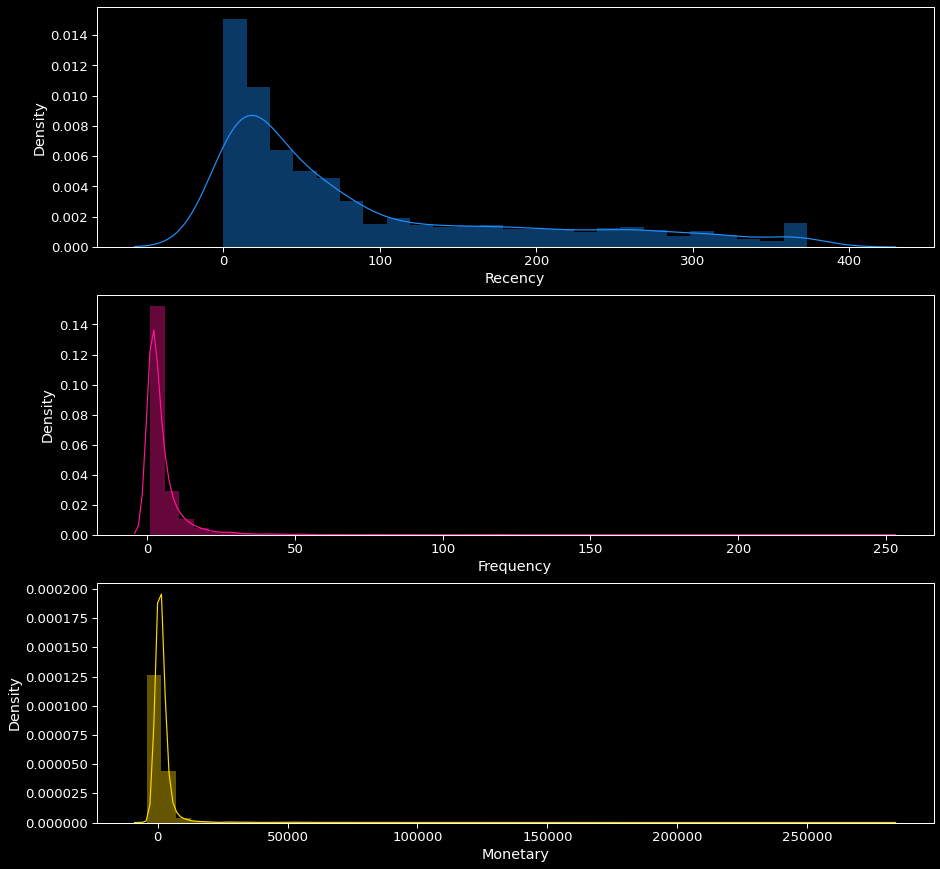

In [125]:
# plot
fig, axes = plt.subplots(3, 1, figsize=(15, 15))
sns.distplot(rfm_table.Recency , color="dodgerblue", ax=axes[0], axlabel='Recency')
sns.distplot(rfm_table.Frequency , color="deeppink", ax=axes[1], axlabel='Frequency')
sns.distplot(rfm_table.Monetary , color="gold", ax=axes[2], axlabel='Monetary')
# plt.xlim(50,75);
plt.show();

#### Here we can observe that the data is highly skewed. So we have to transform and scale the data first because K-Means assumes that the variables should have a symmetric distributions(not skewed) and they should have same average values as well as same variance.

In [127]:
rfm_table.describe().T

count         mean          std      min      25%     50%  \
Recency    4372.0    91.581199   100.772139     0.00   16.000   50.00   
Frequency  4372.0     5.075480     9.338754     1.00    1.000    3.00   
Monetary   4372.0  1893.531433  8218.696204 -4287.63  291.795  644.07   

                75%        max  
Recency     143.000     373.00  
Frequency     5.000     248.00  
Monetary   1608.335  279489.02

In [128]:
rfm_table_scaled = rfm_table.copy()

In [129]:
rfm_table_scaled.Monetary = rfm_table_scaled.Monetary + abs(rfm_table_scaled.Monetary.min()) + 1

In [130]:
rfm_table_scaled.Recency = rfm_table_scaled.Recency + abs(rfm_table_scaled.Recency.min()) + 1

In [131]:
rfm_table_scaled.describe().T

count         mean          std  min       25%     50%       75%  \
Recency    4372.0    92.581199   100.772139  1.0    17.000    51.0   144.000   
Frequency  4372.0     5.075480     9.338754  1.0     1.000     3.0     5.000   
Monetary   4372.0  6182.161433  8218.696204  1.0  4580.425  4932.7  5896.965   

                 max  
Recency       374.00  
Frequency     248.00  
Monetary   283777.65

In [132]:
from sklearn.preprocessing import StandardScaler

In [133]:
log_df = np.log(rfm_table_scaled)

In [134]:
scaler = StandardScaler()
normal_df = scaler.fit_transform(log_df)
normal_df = pd.DataFrame(data=normal_df, index=rfm_table.index, columns=rfm_table.columns)

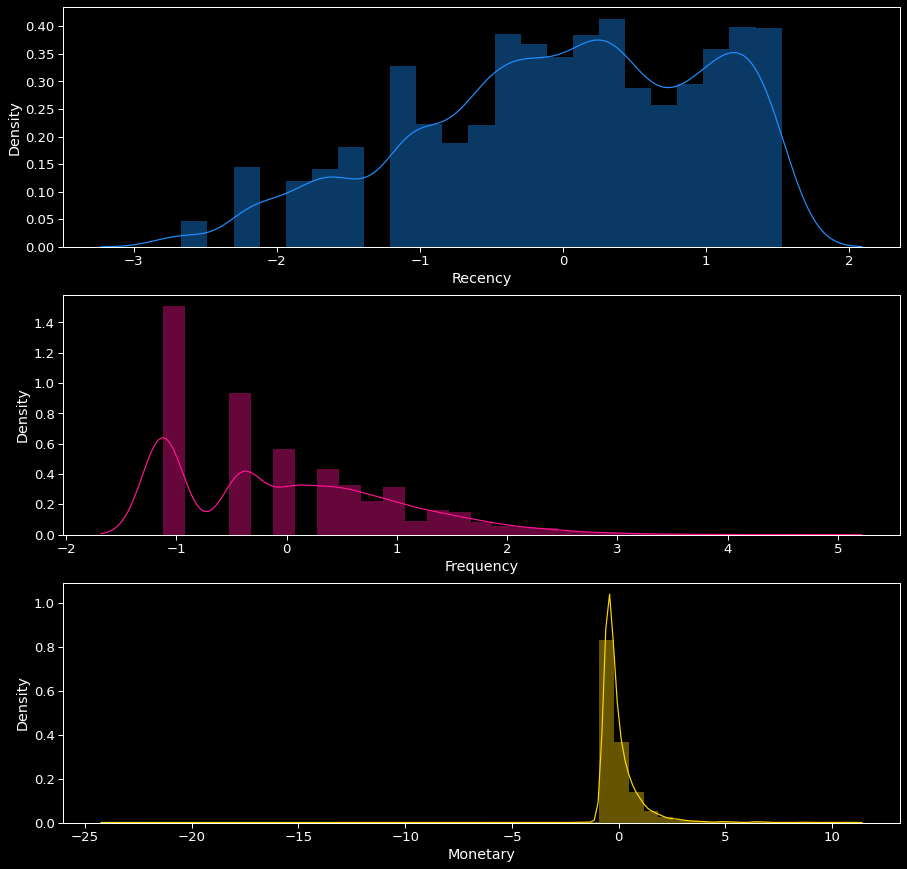

In [135]:
# plot again on the transformed RFM data
fig, axes = plt.subplots(3, 1, figsize=(15, 15))
sns.distplot(normal_df.Recency , color="dodgerblue", ax=axes[0], axlabel='Recency')
sns.distplot(normal_df.Frequency , color="deeppink", ax=axes[1], axlabel='Frequency')
sns.distplot(normal_df.Monetary , color="gold", ax=axes[2], axlabel='Monetary')
plt.show();

In [136]:
# find WCSS
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
wcss = []
for i in range(1,11):
    kmeans = KMeans(n_clusters=i, init='k-means++')
    kmeans.fit(normal_df)
    wcss.append(kmeans.inertia_)

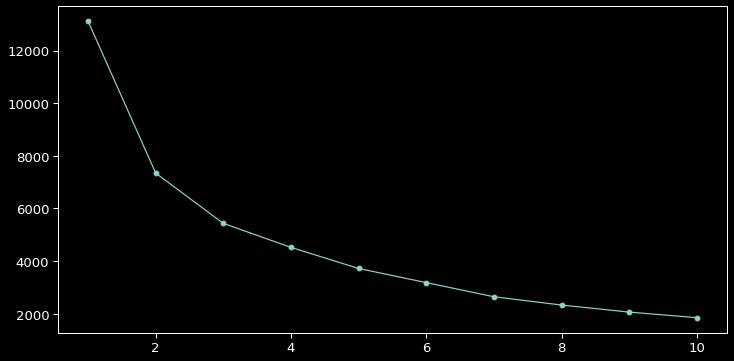

In [137]:
# plot elbow graph
plt.plot(range(1,11),wcss,marker='o');

Silhouette score for number of cluster(s) 2: 0.4405297656150766
Silhouette score for number of cluster(s) 3: 0.39677649451050456
Silhouette score for number of cluster(s) 4: 0.338013340102464
Silhouette score for number of cluster(s) 5: 0.3626494830847667
Silhouette score for number of cluster(s) 6: 0.3649032445702833
Silhouette score for number of cluster(s) 7: 0.354671831939756
Silhouette score for number of cluster(s) 8: 0.34664985914118013
Silhouette score for number of cluster(s) 9: 0.3439470526219597
Silhouette score for number of cluster(s) 10: 0.3526441041738994
Silhouette score for number of cluster(s) 11: 0.3618099356284099


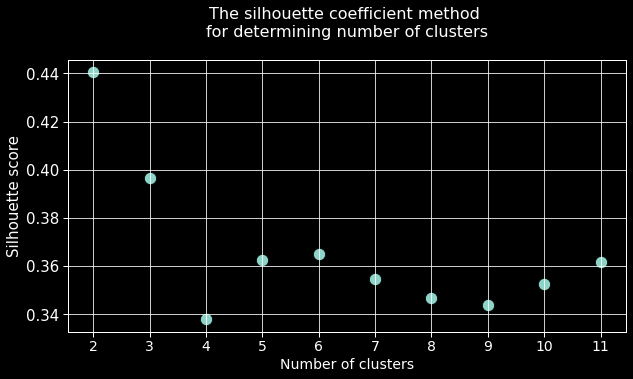

In [138]:
from sklearn.metrics import silhouette_score
wcss_silhouette = []
for i in range(2,12):
    km = KMeans(n_clusters=i, random_state=0,init='k-means++').fit(normal_df)
    preds = km.predict(normal_df)    
    silhouette = silhouette_score(normal_df,preds)
    wcss_silhouette.append(silhouette)
    print("Silhouette score for number of cluster(s) {}: {}".format(i,silhouette))

plt.figure(figsize=(10,5))
plt.title("The silhouette coefficient method \nfor determining number of clusters\n",fontsize=16)
plt.scatter(x=[i for i in range(2,12)],y=wcss_silhouette,s=150,edgecolor='k')
plt.grid(True)
plt.xlabel("Number of clusters",fontsize=14)
plt.ylabel("Silhouette score",fontsize=15)
plt.xticks([i for i in range(2,12)],fontsize=14)
plt.yticks(fontsize=15)
plt.show()

#### Here we can clearly see that optimum number of cluster should be 4 not 2 or 3. Because that is the only point after which the mean cluster distance looks to be plateaued after a steep downfall. So we will assume the 4 number of clusters as best for grouping of customer segments.

#### Now let's apply K-Means on 4 clusters to segregate the customer base.

In [139]:
kmeans = KMeans(n_clusters=4, random_state=1, init='k-means++')
kmeans.fit(normal_df)
cluster_labels = kmeans.labels_

In [140]:
kmeans

KMeans(n_clusters=4, random_state=1)

In [141]:
print(f"Shape of cluster label array is {cluster_labels.shape}")
print(f"Shape of RFM segment dataframe is {rfm_segment.shape}")

Shape of cluster label array is (4372,)
Shape of RFM segment dataframe is (4372, 9)


In [142]:
# Assign the clusters as column to each customer
Cluster_table = rfm_segment.assign(Cluster = cluster_labels)

In [145]:
Cluster_table.sample(10)

CustomerID  Recency  Frequency  Monetary  R_Quartile  F_Quartile  \
2710       16015        3          4    689.70           4           3   
1772       14739        2          8   3899.10           4           4   
3793       17503        2          2    558.96           4           2   
1036       13735       24          8   2764.48           3           4   
498        12989        3         19   6854.51           4           4   
457        12930       78          4    409.90           2           3   
1379       14208       94          1    151.74           2           1   
341        12762        7          2   1898.52           4           2   
3480       17058       81          3   1179.89           2           2   
3117       16565      364          1    173.70           1           1   

      M_Quartile RFMScore          Segment  Cluster  
2710           3      433           others        3  
1772           4      444   Best Customers        2  
3793           2      422           others        3  
1036           4      344  Loyal Customers        2  
498            4      444   Best Customers        2  
457            2      232           others        3  
1379           1      211           others        0  
341            4      424           others        3  
3480           3      223           others        3  
3117           1      111           others        0

In [146]:
Cluster_table[Cluster_table.Cluster == 3].sample(5)

CustomerID  Recency  Frequency  Monetary  R_Quartile  F_Quartile  \
2588       15836       45          2    117.47           3           2   
4027       17817        4          3    387.68           4           2   
2093       15181       66          5    680.28           2           3   
3492       17073       17          4   1446.09           3           3   
3335       16852       10          2    144.91           4           2   

      M_Quartile RFMScore Segment  Cluster  
2588           1      321  others        3  
4027           2      422  others        3  
2093           3      233  others        3  
3492           3      333  others        3  
3335           1      421  others        3

In [147]:
Cluster_table[Cluster_table.Cluster == 2].sample(5)

CustomerID  Recency  Frequency  Monetary  R_Quartile  F_Quartile  \
4340       18241        9         18   2058.09           4           4   
2430       15628        4         10   2865.64           4           4   
111        12483       17         13   2327.13           3           4   
3794       17504      206         10   2745.28           1           4   
1396       14226       28          7   2184.24           3           4   

      M_Quartile RFMScore          Segment  Cluster  
4340           4      444   Best Customers        2  
2430           4      444   Best Customers        2  
111            4      344  Loyal Customers        2  
3794           4      144   Lost Customers        2  
1396           4      344  Loyal Customers        2

In [148]:
Cluster_table[Cluster_table.Cluster == 1].sample(5)

CustomerID  Recency  Frequency  Monetary  R_Quartile  F_Quartile  \
698        13263        1         35   7436.93           4           4   
3925       17675        1         41  20098.10           4           4   
330        12748        0        224  28405.56           4           4   
1447       14298        3         45  50862.44           4           4   
1206       13969        7         20   8956.92           4           4   

      M_Quartile RFMScore         Segment  Cluster  
698            4      444  Best Customers        1  
3925           4      444  Best Customers        1  
330            4      444  Best Customers        1  
1447           4      444  Best Customers        1  
1206           4      444  Best Customers        1

In [149]:
Cluster_table[Cluster_table.Cluster == 0].sample(5)

CustomerID  Recency  Frequency  Monetary  R_Quartile  F_Quartile  \
4246       18119      367          1    180.70           1           1   
303        12715      106          1    343.36           2           1   
2410       15603       78          1     48.48           2           1   
2047       15120      129          2    343.82           2           2   
2753       16073      291          2     94.35           1           2   

      M_Quartile RFMScore Segment  Cluster  
4246           1      111  others        0  
303            2      212  others        0  
2410           1      211  others        0  
2047           2      222  others        0  
2753           1      121  others        0

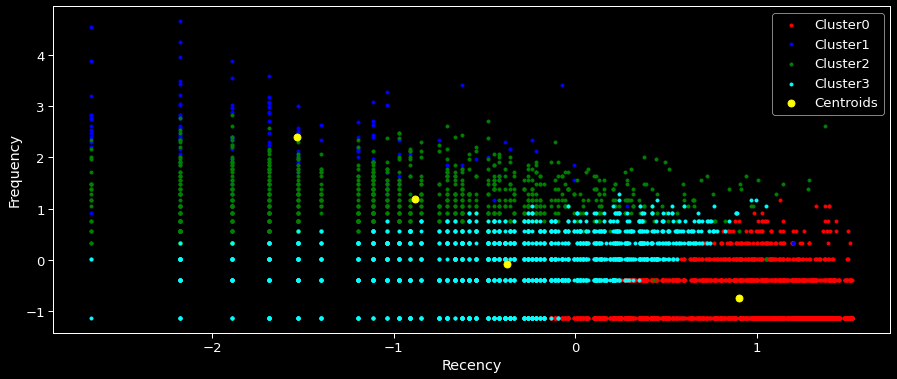

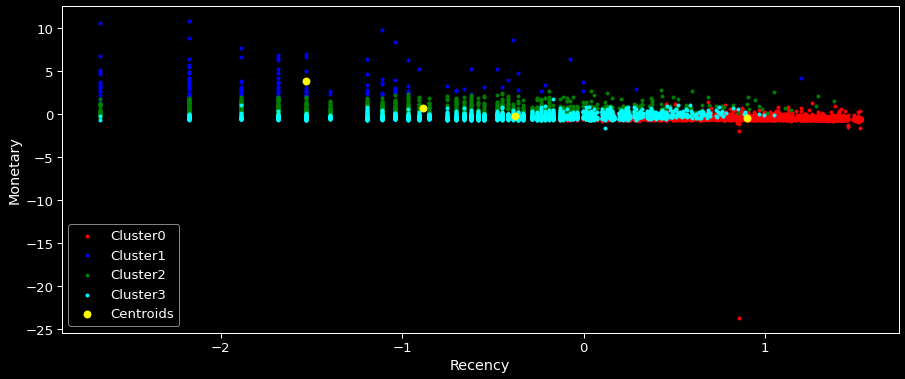

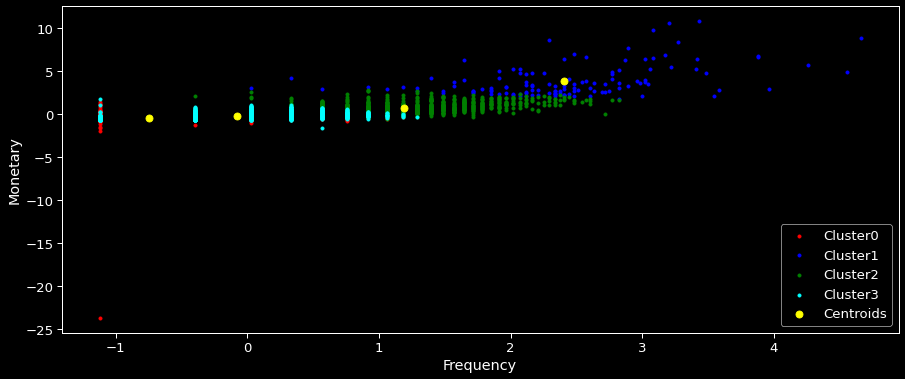

In [151]:
# Plotting two dimesional plots of each attributes respectively.
X = normal_df.iloc[:,0:3].values
count=X.shape[1]
for i in range(0,count):
    for j in range(i+1,count):
        plt.figure(figsize=(15,6));
        plt.scatter(X[cluster_labels == 0, i], X[cluster_labels == 0, j], s = 10, c = 'red', label = 'Cluster0')
        plt.scatter(X[cluster_labels == 1, i], X[cluster_labels == 1, j], s = 10, c = 'blue', label = 'Cluster1')
        plt.scatter(X[cluster_labels == 2, i], X[cluster_labels == 2, j], s = 10, c = 'green', label = 'Cluster2')
        plt.scatter(X[cluster_labels == 3, i], X[cluster_labels == 3, j], s = 10, c = 'cyan', label = 'Cluster3')
        plt.scatter(kmeans.cluster_centers_[:,i], kmeans.cluster_centers_[:,j], s = 50, c = 'yellow', label = 'Centroids')
        plt.xlabel(normal_df.columns[i])
        plt.ylabel(normal_df.columns[j])
        plt.legend()        
        plt.show();

In [152]:
# Assign Cluster values to each customer in normalized dataframe
normal_df = normal_df.assign(Cluster = cluster_labels)

# Melt normalized dataframe into long form to have all metric in same column
normal_melt = pd.melt(normal_df.reset_index(),
                      id_vars=['CustomerID','Cluster'],
                      value_vars=['Recency', 'Frequency', 'Monetary'],
                      var_name='Metric',
                      value_name='Value')
normal_melt.head()

CustomerID  Cluster   Metric     Value
0       12346        0  Recency  1.428946
1       12347        2  Recency -1.889472
2       12348        3  Recency  0.398257
3       12349        3  Recency -0.582976
4       12350        0  Recency  1.395605

In [153]:
# Assign Cluster labels to RFM table
rfm_table_cluster = rfm_table.assign(Cluster = cluster_labels)

# Average attributes for each cluster
cluster_avg = rfm_table_cluster.groupby(['Cluster']).mean() 

# Calculate the population average
population_avg = rfm_table.mean()

# Calculate relative importance of attributes by 
relative_imp = cluster_avg / population_avg - 1

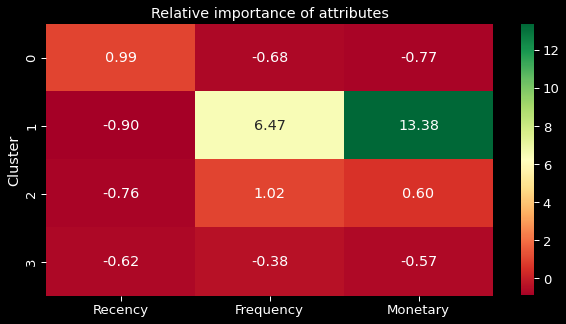

In [154]:
plt.figure(figsize=(10, 5))
plt.title('Relative importance of attributes')
sns.heatmap(data=relative_imp, annot=True, fmt='.2f', cmap='RdYlGn')
plt.show();